In [1]:
import os
import pandas as pd
pd.set_option('display.max_columns', None)
pd.option_context('mode.use_inf_as_na', True)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

from scipy.stats import chi2_contingency, skew
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.model_selection import KFold,train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import optuna

import joblib

In [2]:
base_path = '/kaggle/input/house-prices-advanced-regression-techniques/'

df_train = pd.read_csv(os.path.join(base_path, "train.csv"))
df_test = pd.read_csv(os.path.join(base_path, "test.csv"))
df_sample_submission = pd.read_csv(os.path.join(base_path,"sample_submission.csv"))

In [3]:
print(f"Training Data size: {df_train.shape}")
print(f"Test Data size: {df_test.shape}")
print(f"Sample submission size: {df_sample_submission.shape}")

Training Data size: (1460, 81)
Test Data size: (1459, 80)
Sample submission size: (1459, 2)


In [4]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

As we can see here, we have features with different data types

- int64
- float64
- object

#### Check for null values

In [6]:
df_train.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
Id                 0
dtype: int64

In [7]:
(df_train.isnull().sum().sort_values(ascending=False).head(20)/len(df_train))*100

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
MasVnrType      59.726027
FireplaceQu     47.260274
LotFrontage     17.739726
GarageYrBlt      5.547945
GarageCond       5.547945
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrArea       0.547945
Electrical       0.068493
Id               0.000000
dtype: float64

As you can see above, columns `PoolQC`, `MiscFeature`, `Alley`, `Fence`, `MasVnrType` missing more than 60% value

### Let'd do some EDA

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


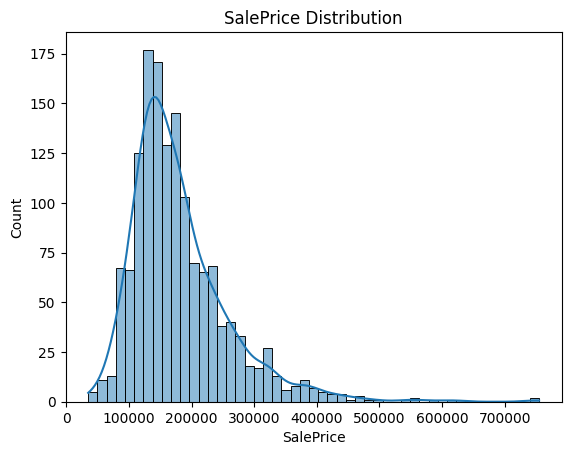

In [8]:
sns.histplot(df_train['SalePrice'],kde=True)
plt.title("SalePrice Distribution")
plt.show()

We can clearly see that `SalePrice` is skewed. (We need to apply log transformation.

In [9]:
def get_categorical_columns(
    df: pd.DataFrame,
    max_unique_ratio: float = 0.05
) -> list:
    """
    Identify categorical columns including:
    - object
    - category
    - numeric columns with low unique ratio
    """
    categorical_cols = []
    total_rows = len(df)

    for col in df.columns:
        if df[col].dtype in ["object", "category"]:
            categorical_cols.append(col)
        elif pd.api.types.is_numeric_dtype(df[col]):
            unique_ratio = df[col].nunique() / total_rows
            if unique_ratio <= max_unique_ratio:
                categorical_cols.append(col)

    return categorical_cols


def get_numerical_columns(df: pd.DataFrame) -> list:
    """
    Return list of numerical columns (int & float).
    """
    return df.select_dtypes(include=["number"]).columns.tolist()



def label_encode_columns(df, columns):
    df = df.copy()
    encoder = LabelEncoder()

    for col in columns:
        df[col] = encoder.fit_transform(df[col].astype(str))

    return df

In [10]:
categorical_columns = get_categorical_columns(df_train)
numeric_columns = list(set(df_train.drop(columns=['Id', 'SalePrice']).columns) - set(categorical_columns))

In [11]:
len(categorical_columns), len(numeric_columns)

(62, 17)

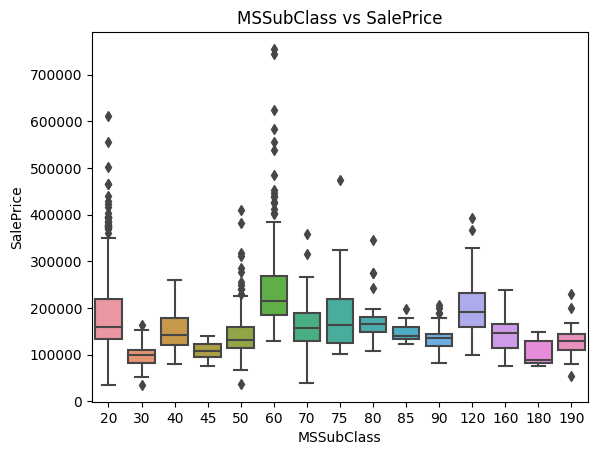

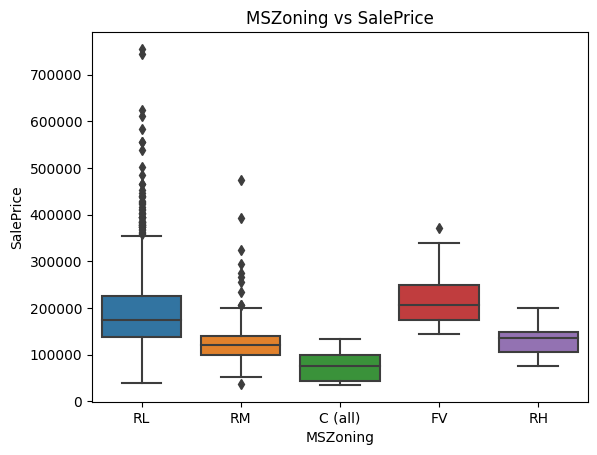

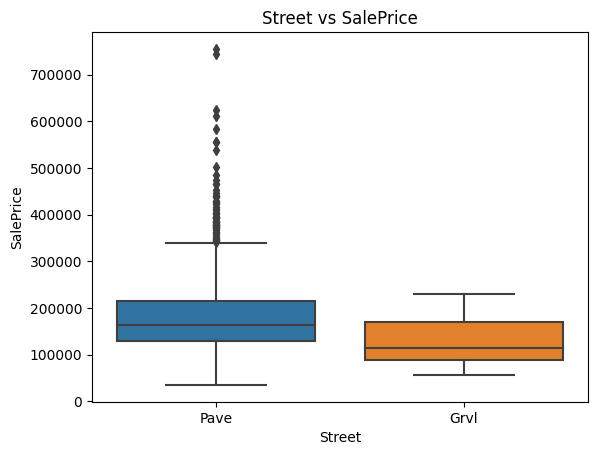

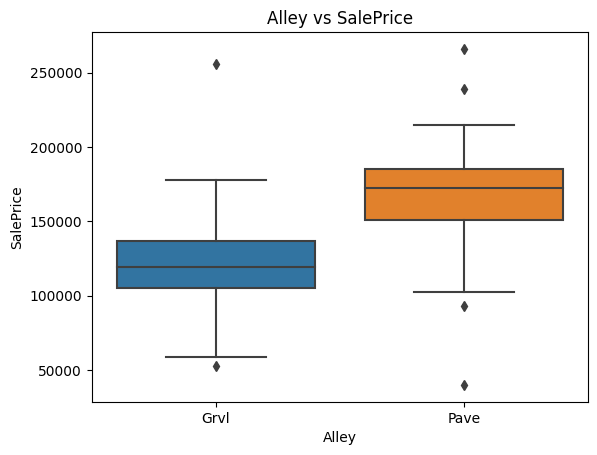

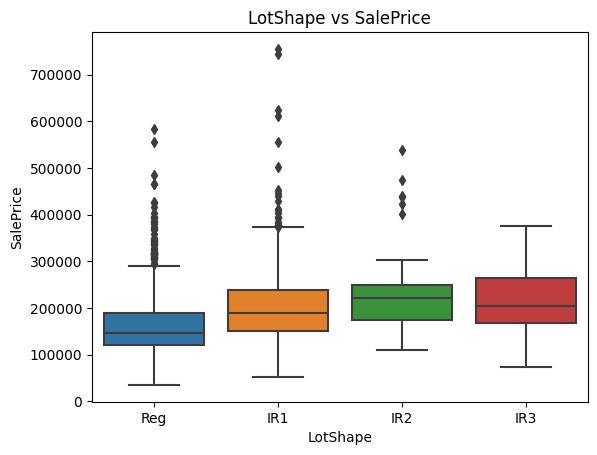

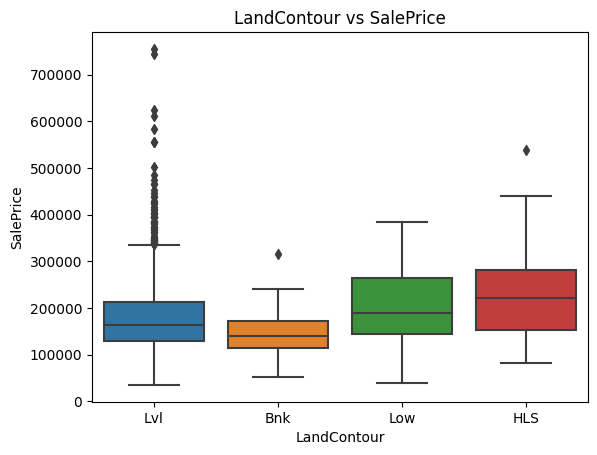

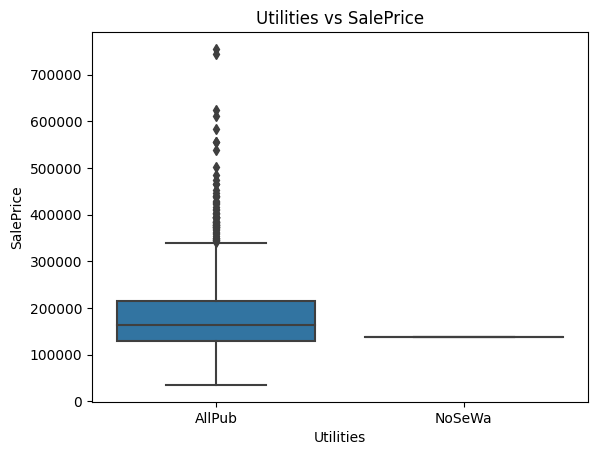

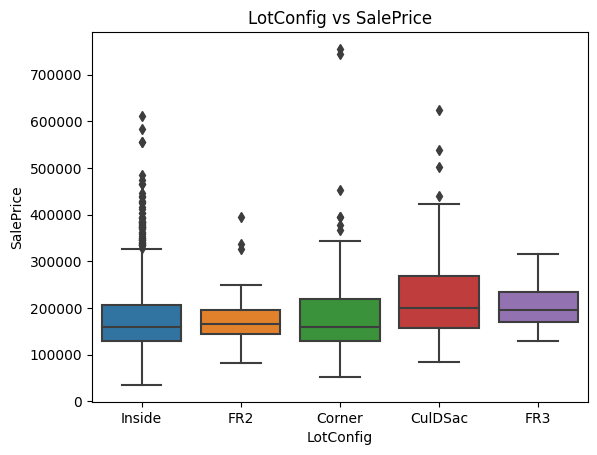

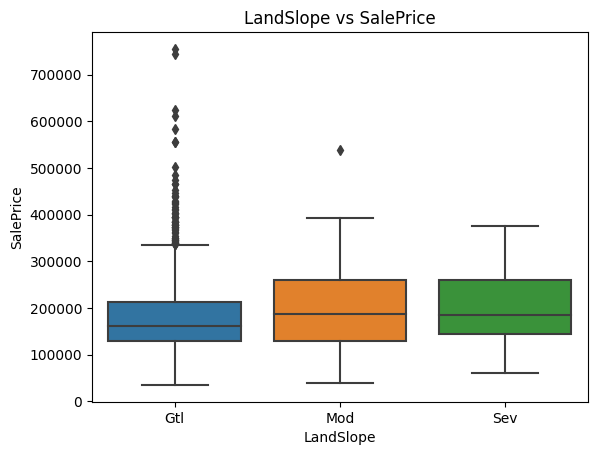

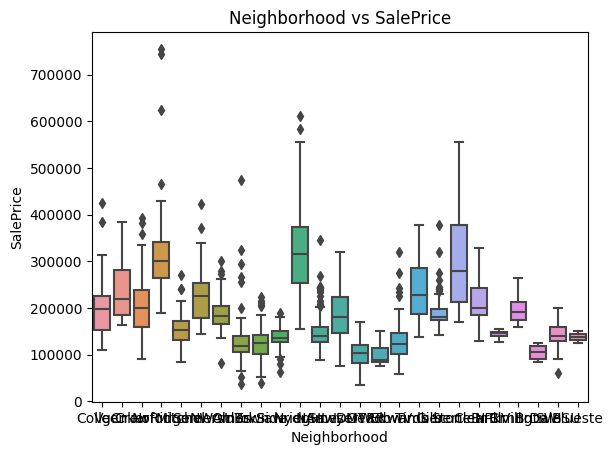

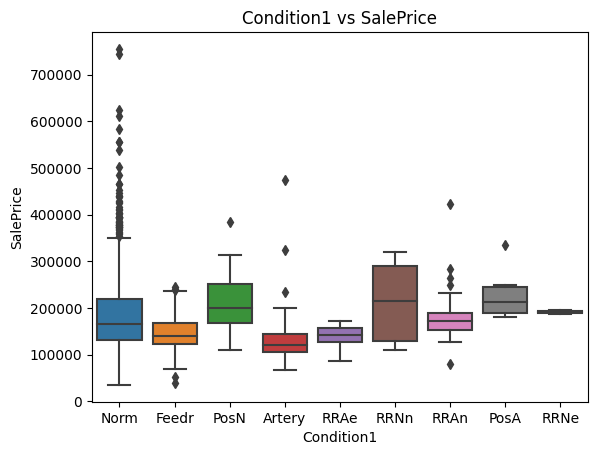

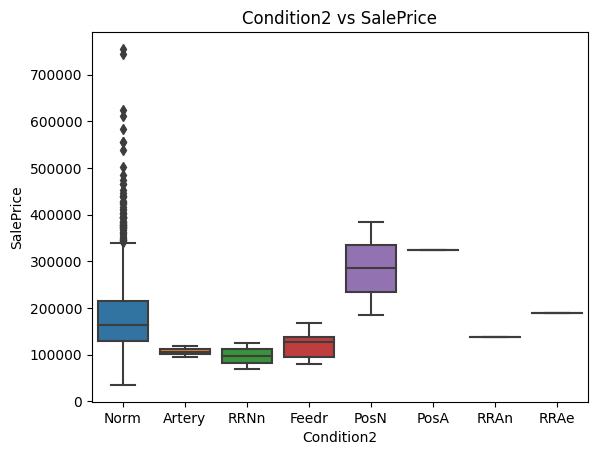

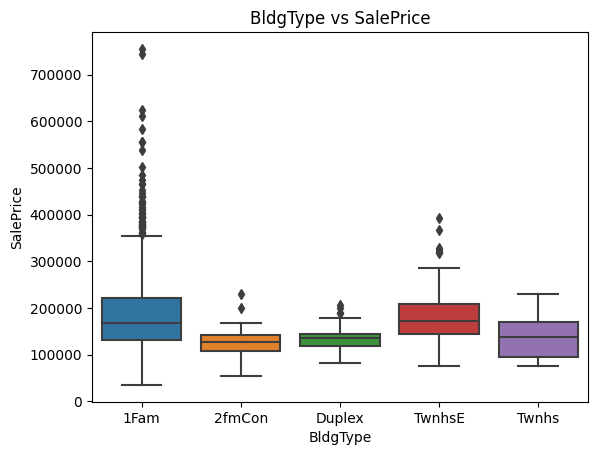

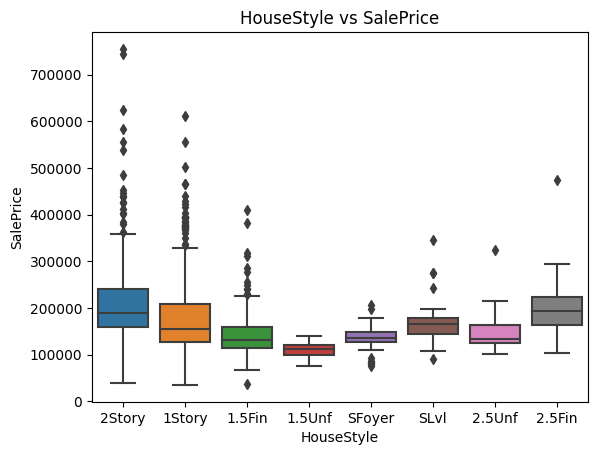

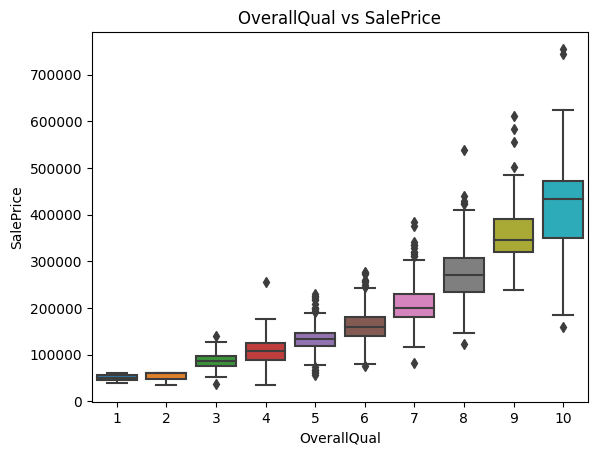

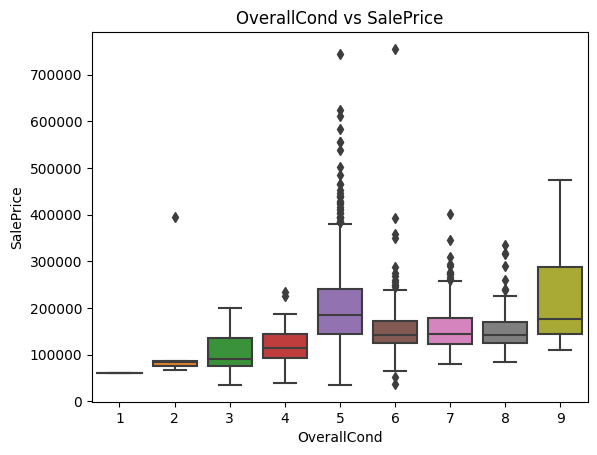

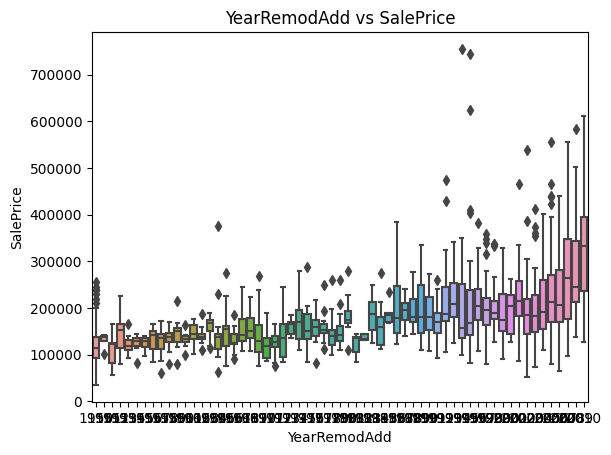

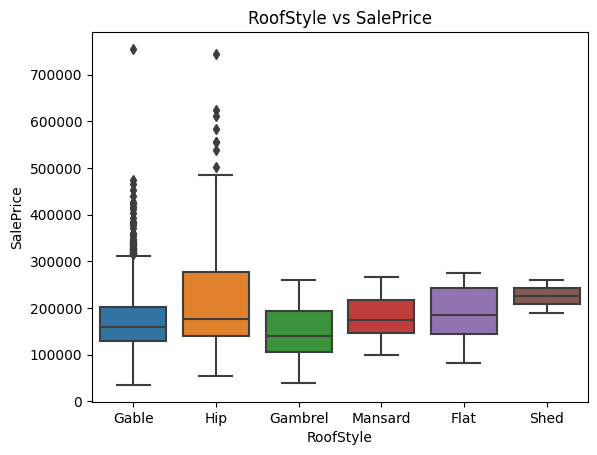

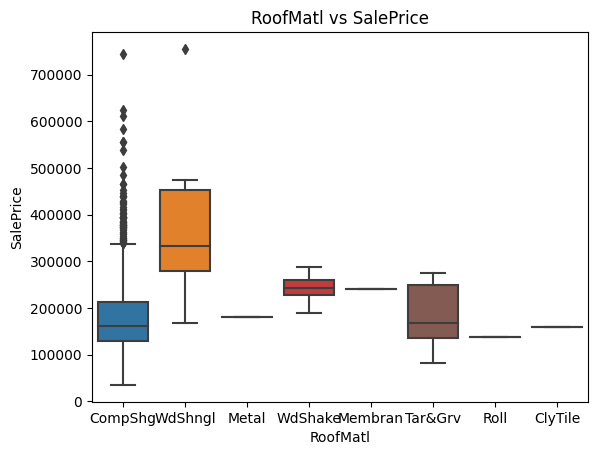

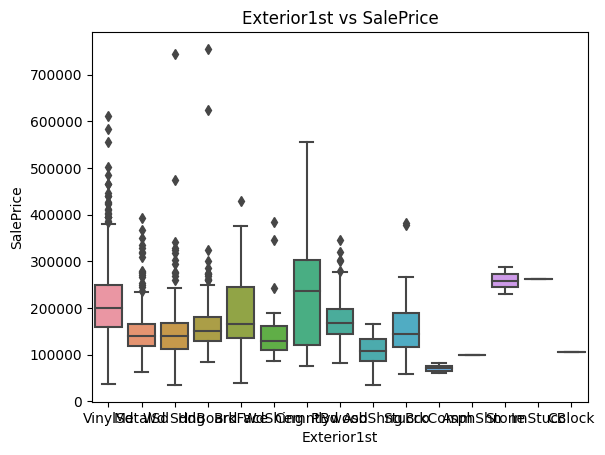

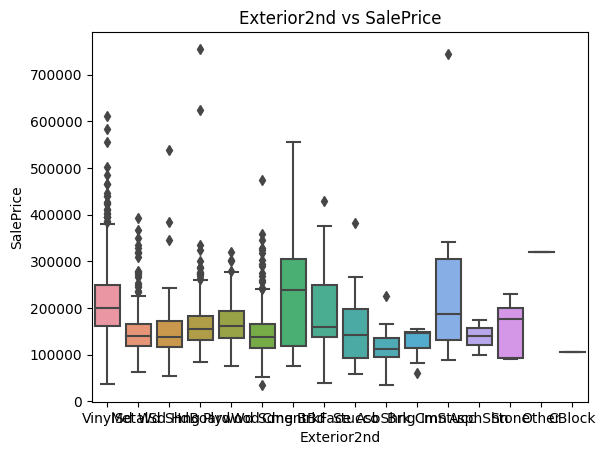

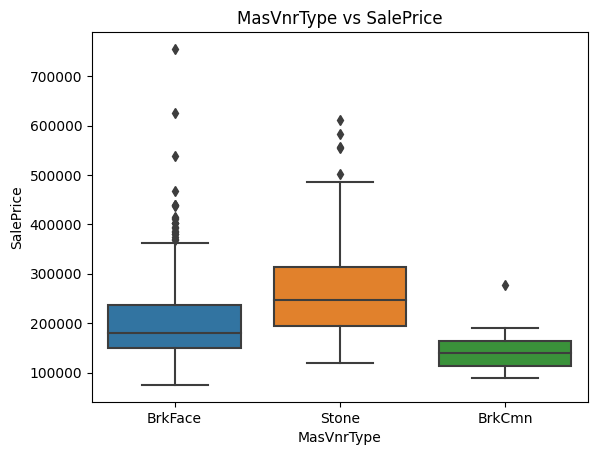

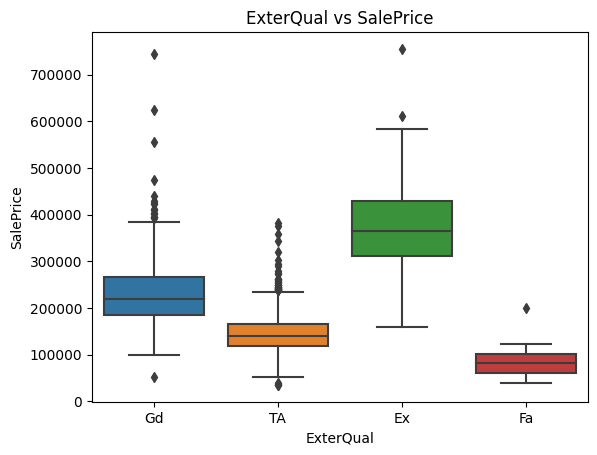

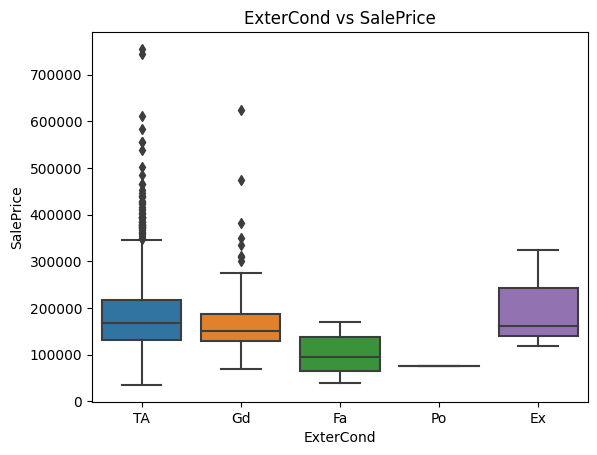

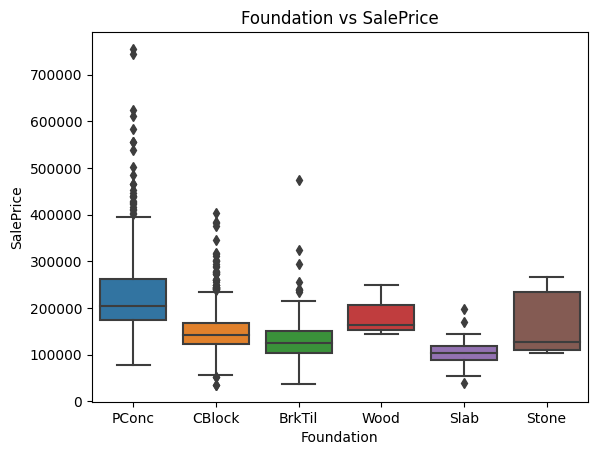

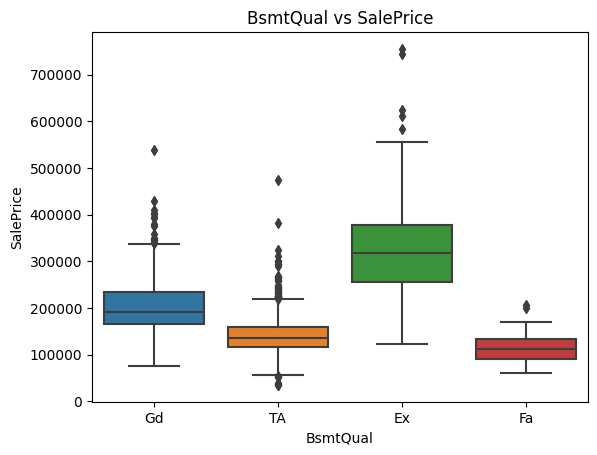

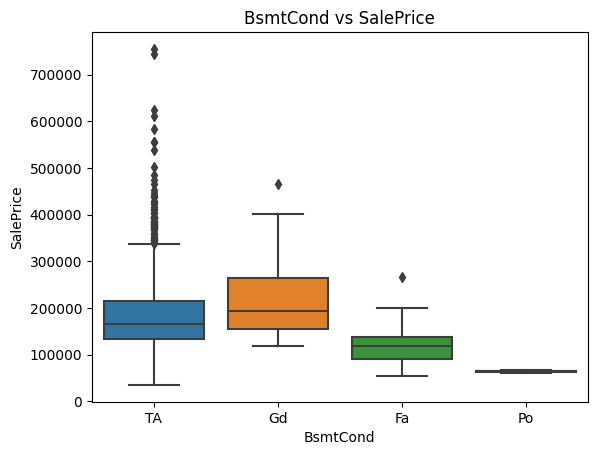

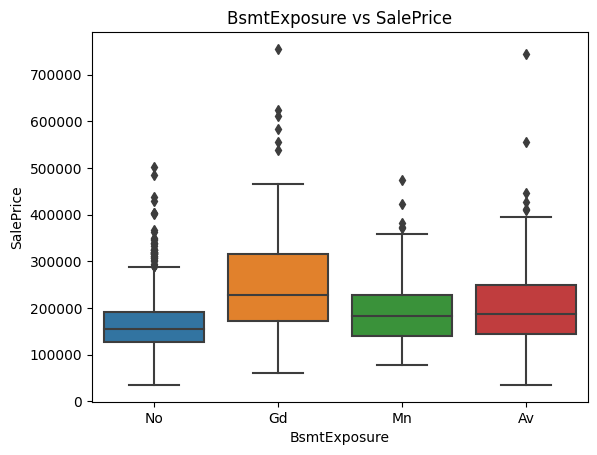

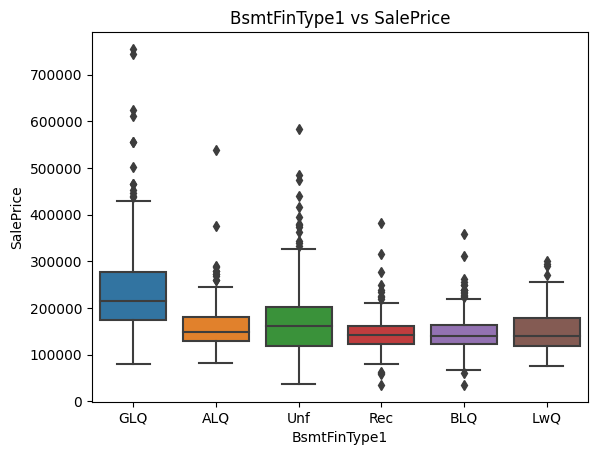

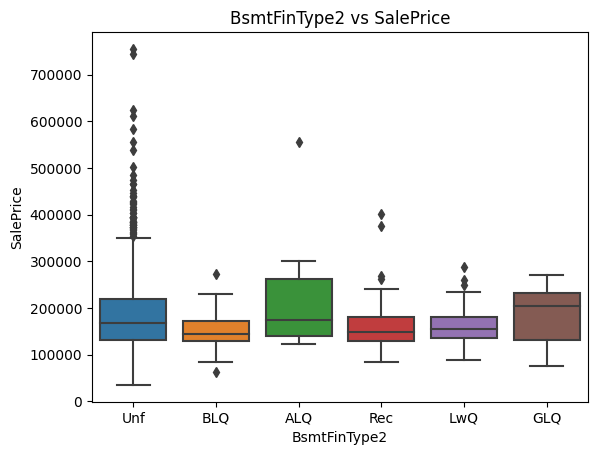

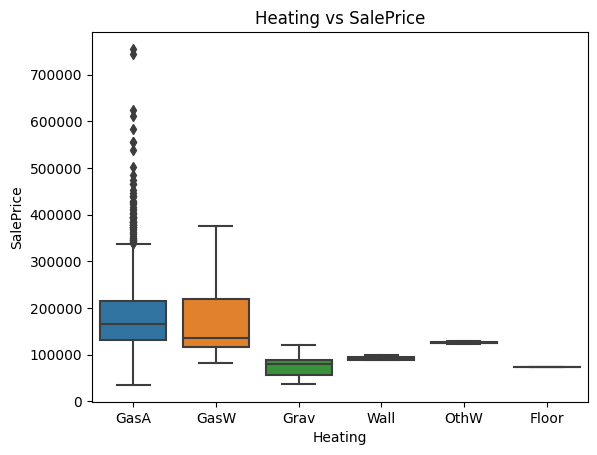

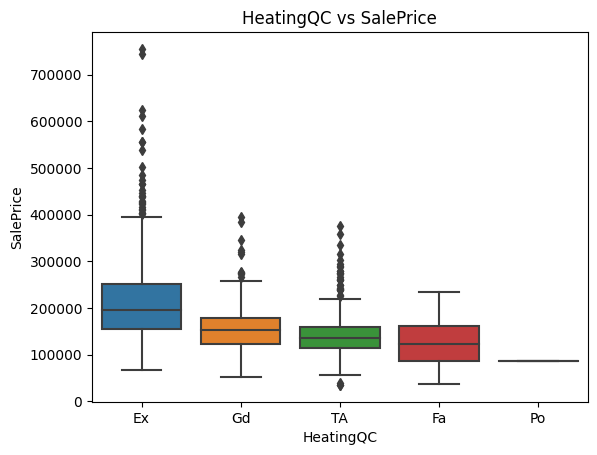

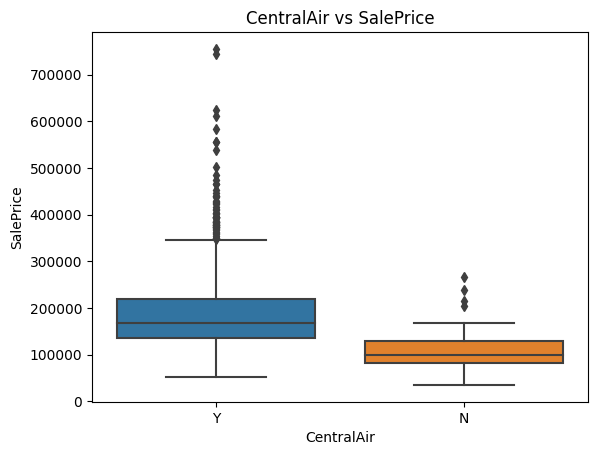

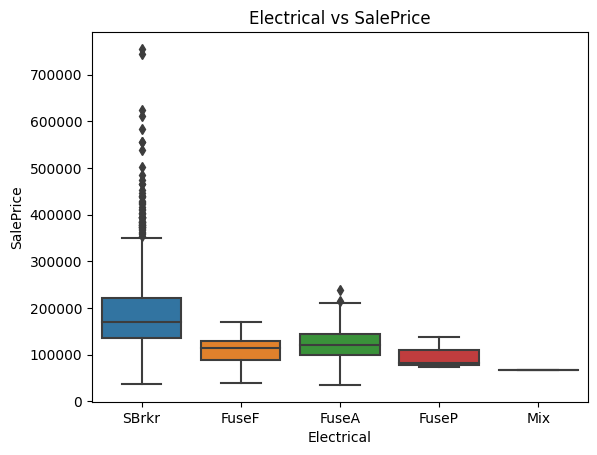

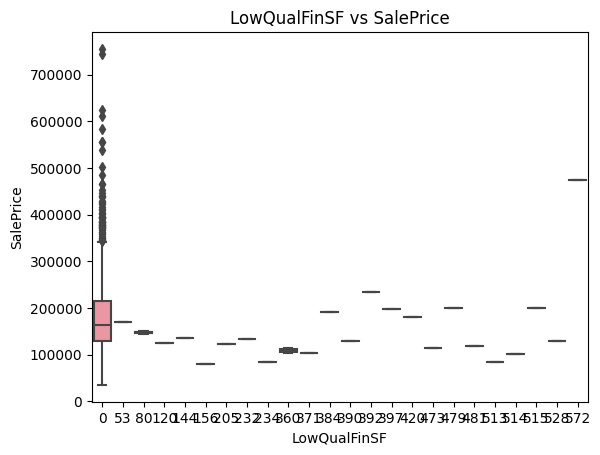

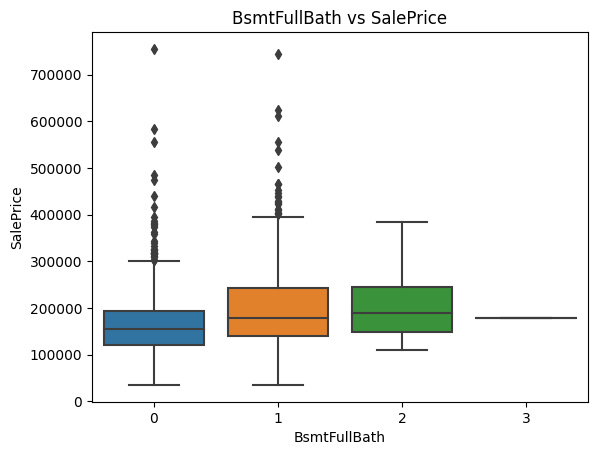

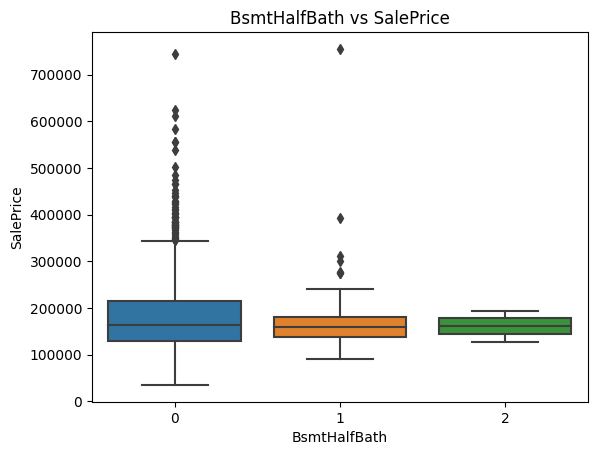

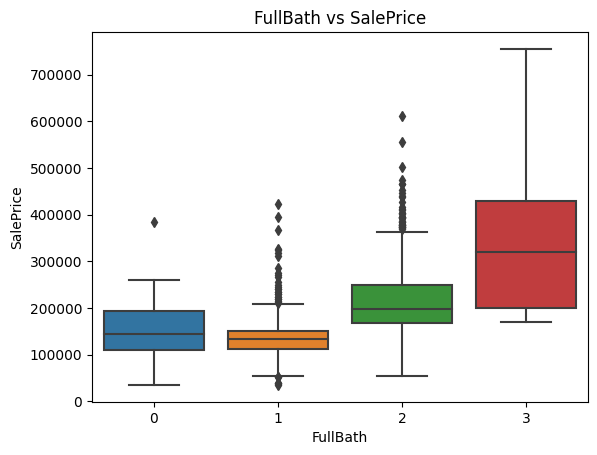

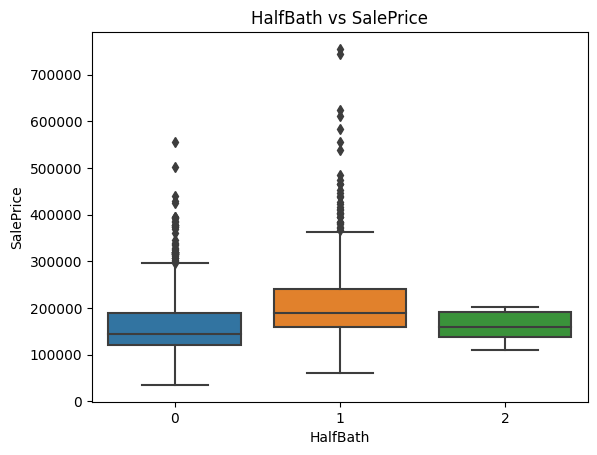

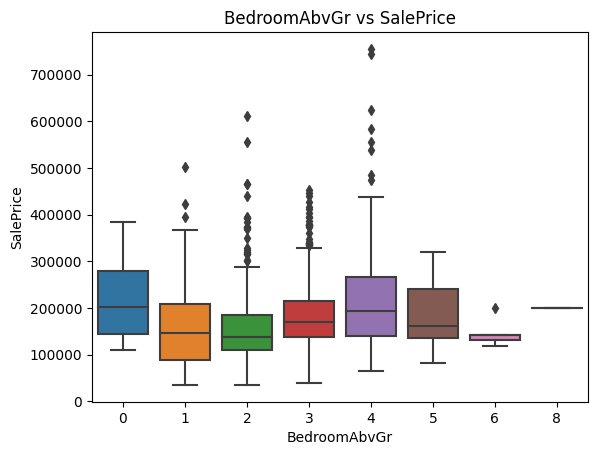

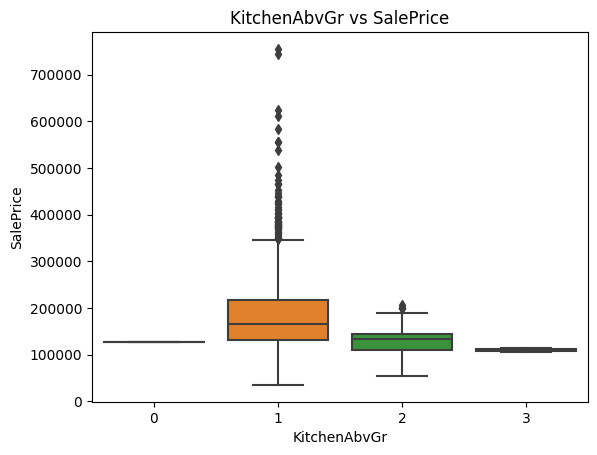

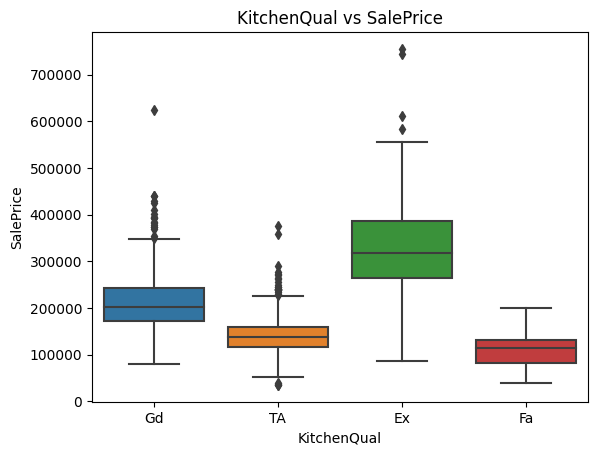

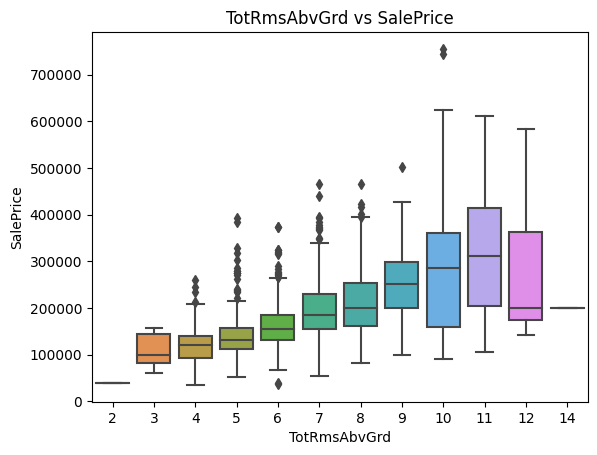

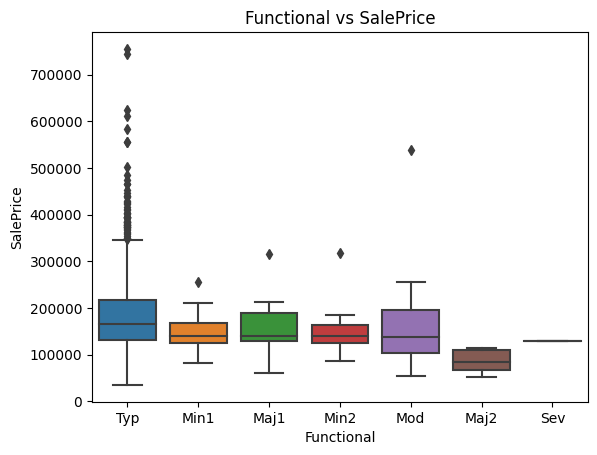

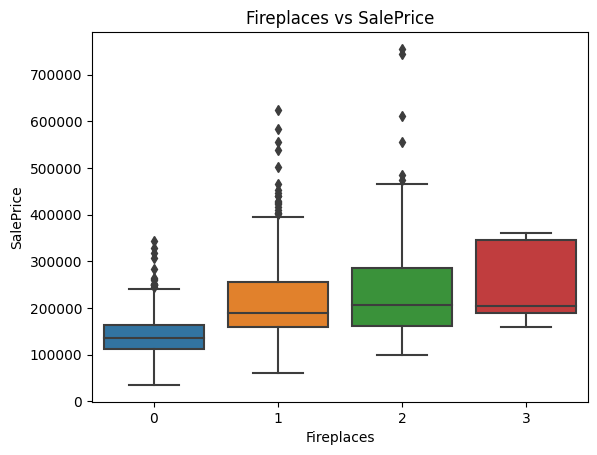

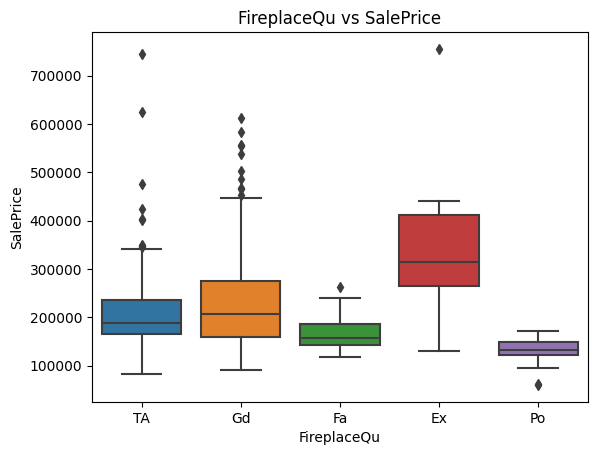

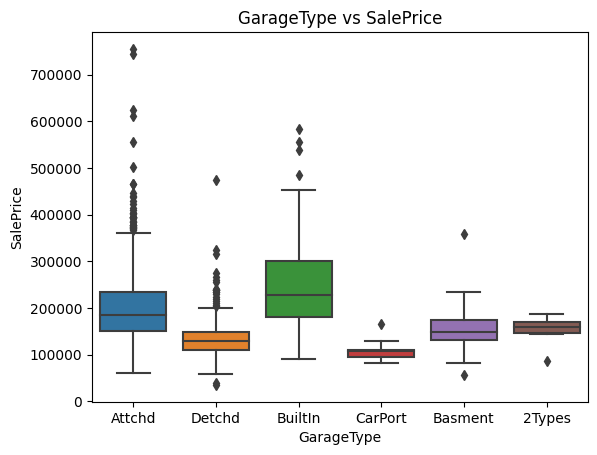

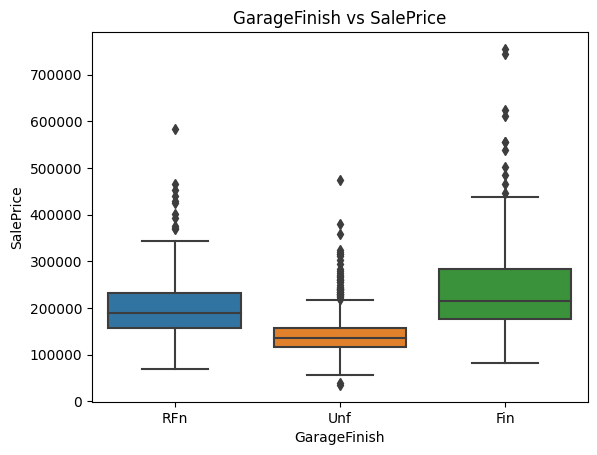

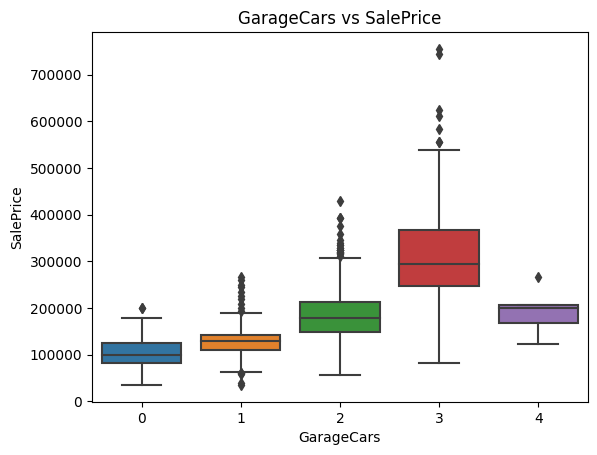

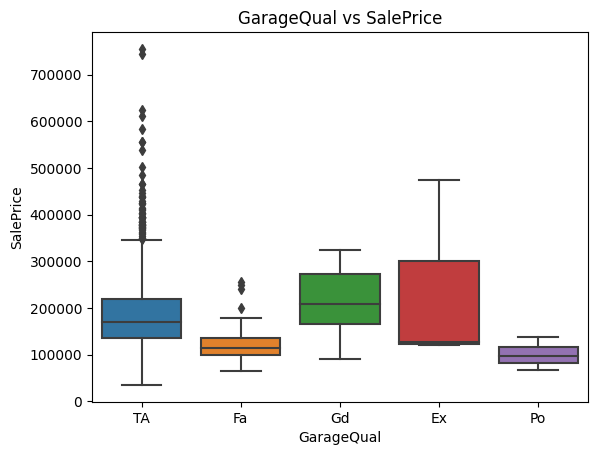

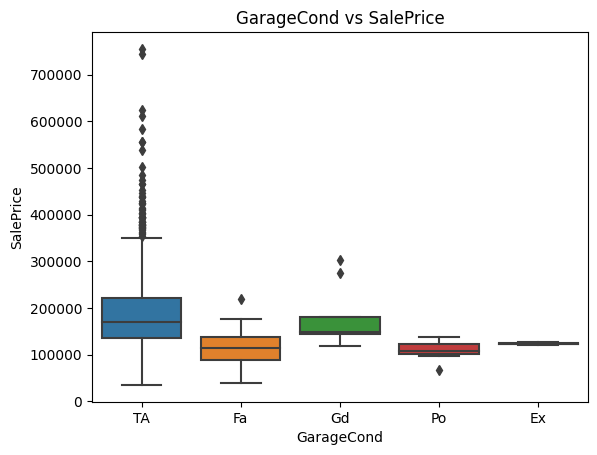

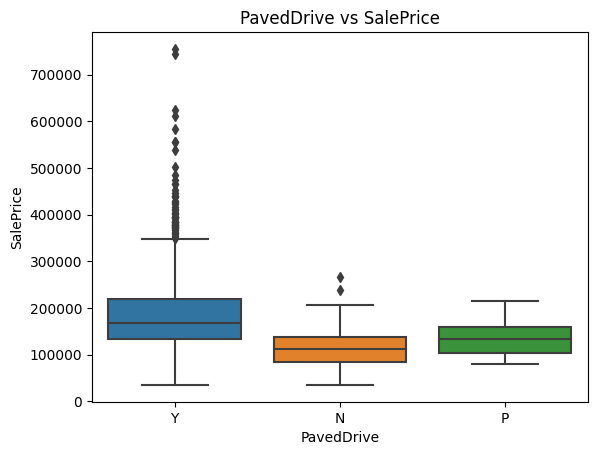

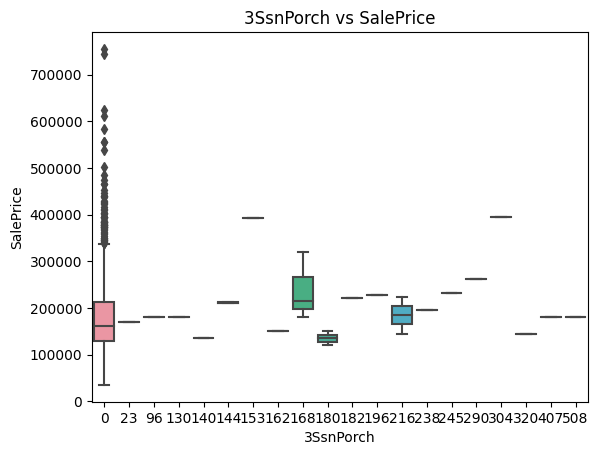

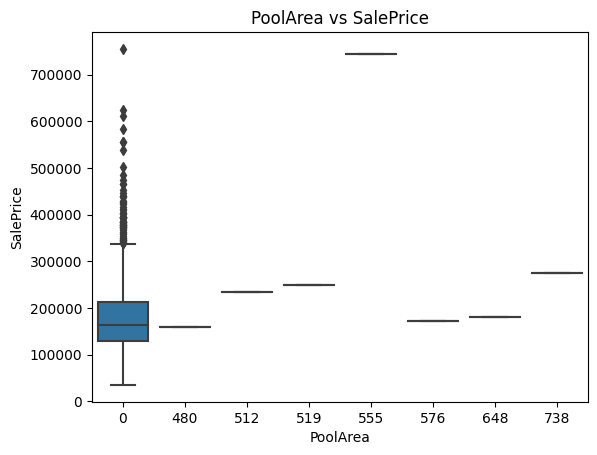

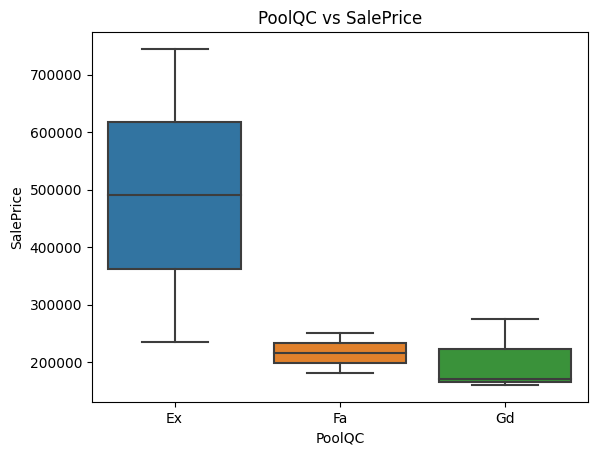

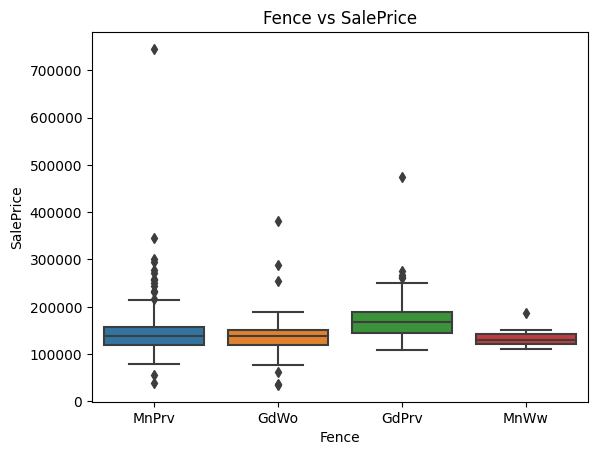

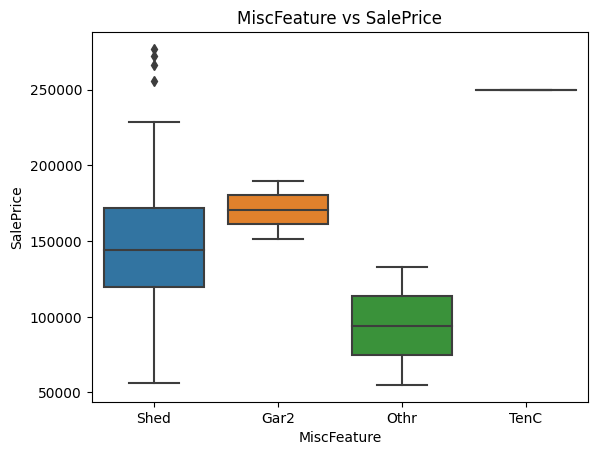

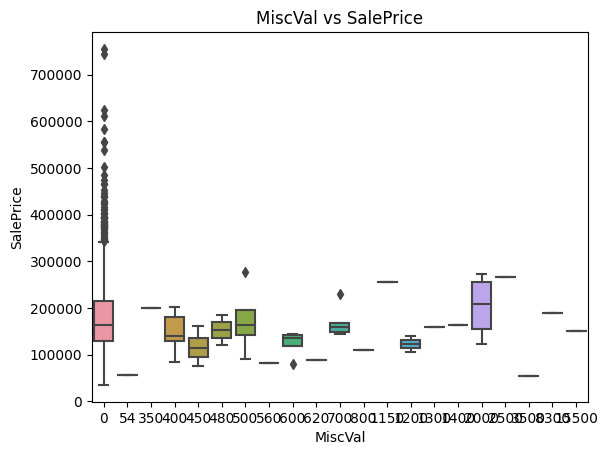

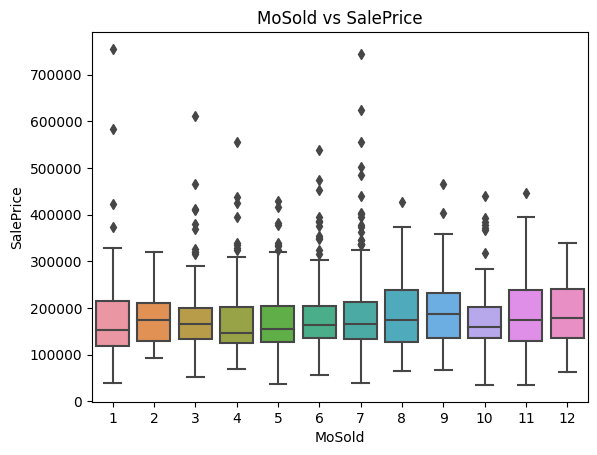

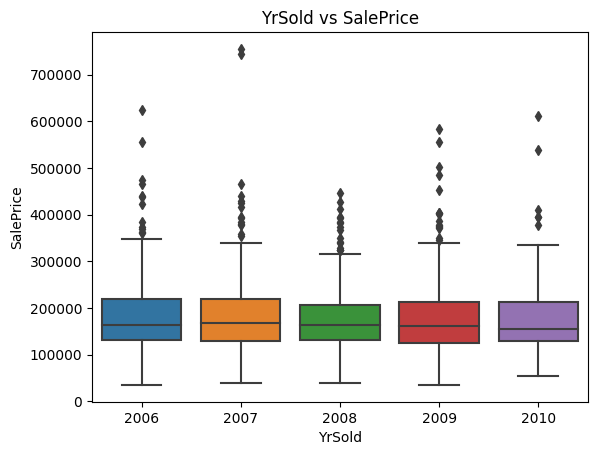

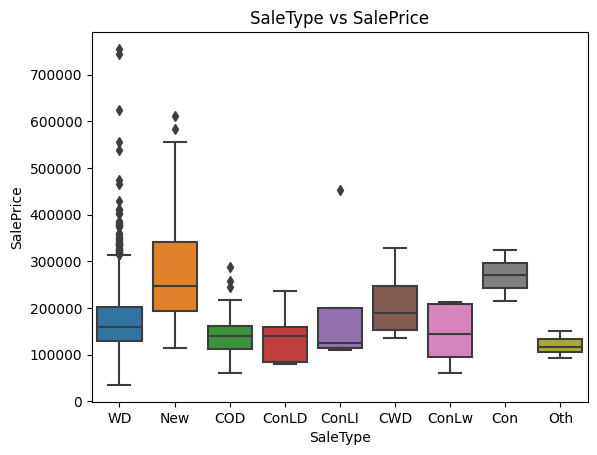

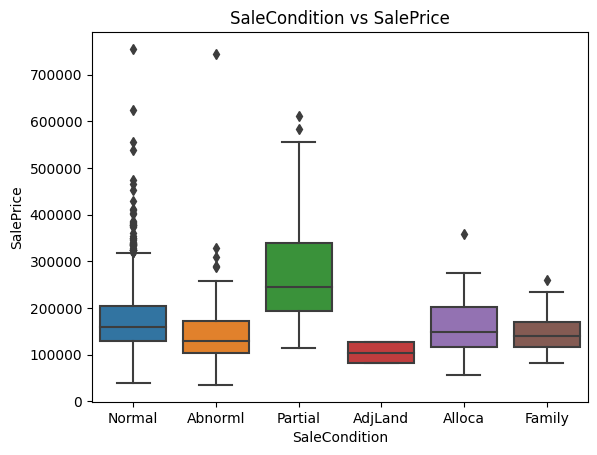

In [12]:
for col in categorical_columns:
    sns.boxplot(x=f'{col}',y='SalePrice',data=df_train)
    plt.title(f'{col} vs SalePrice')
    plt.show()

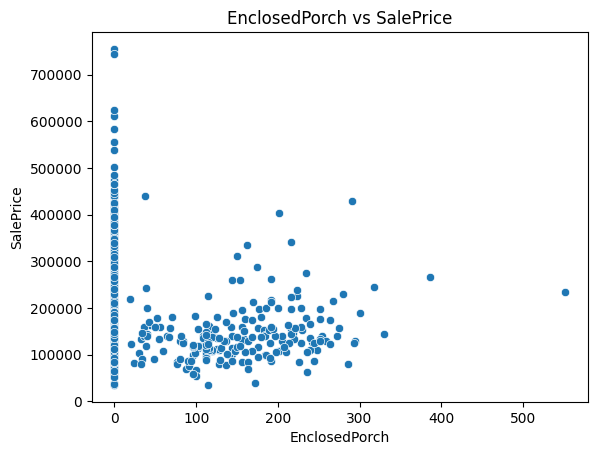

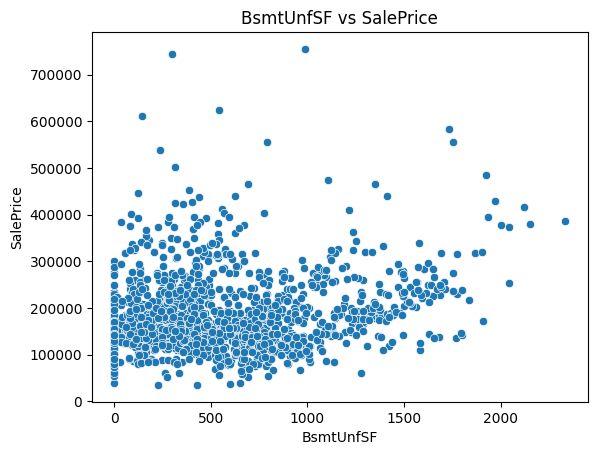

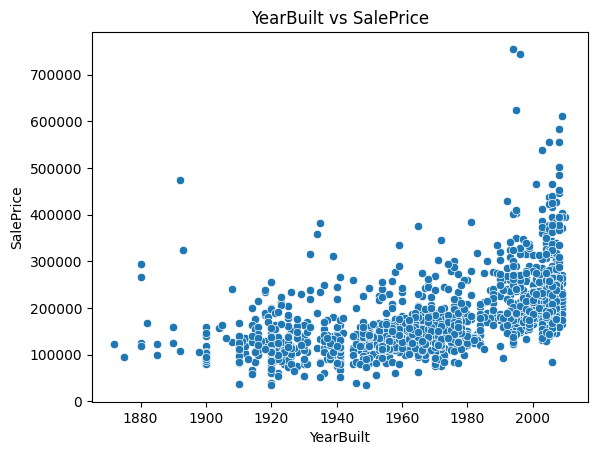

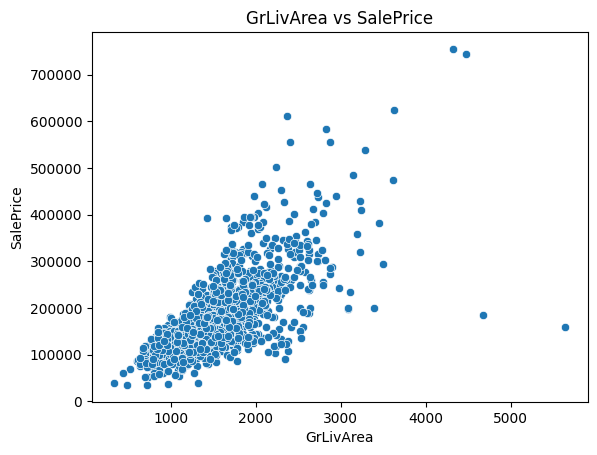

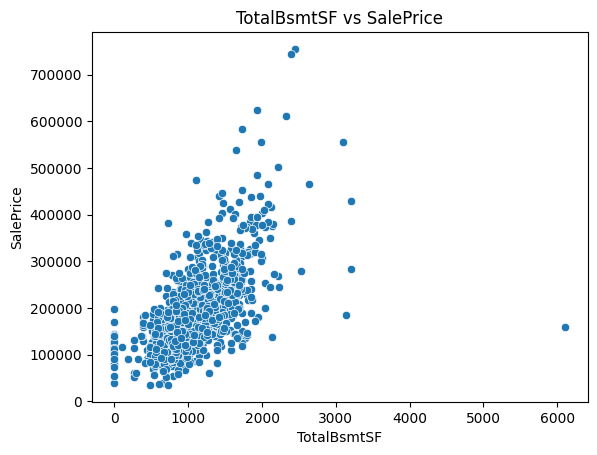

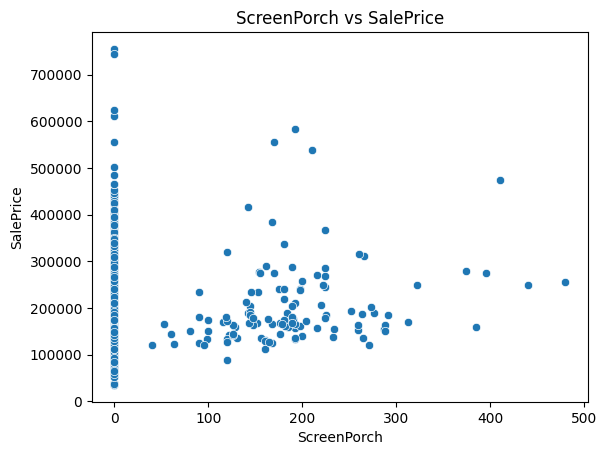

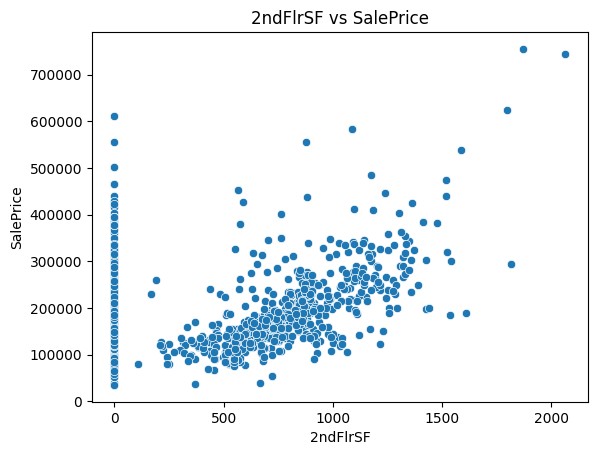

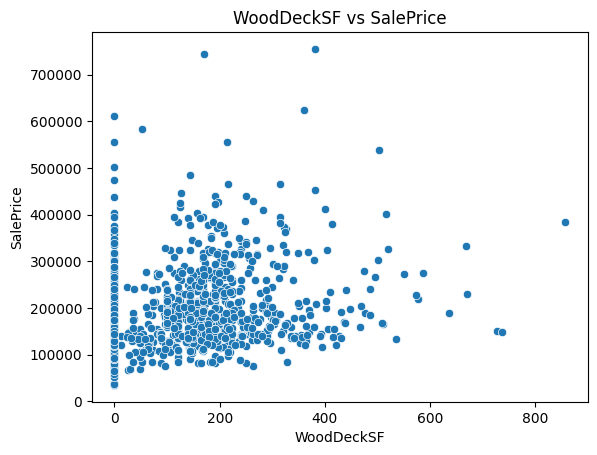

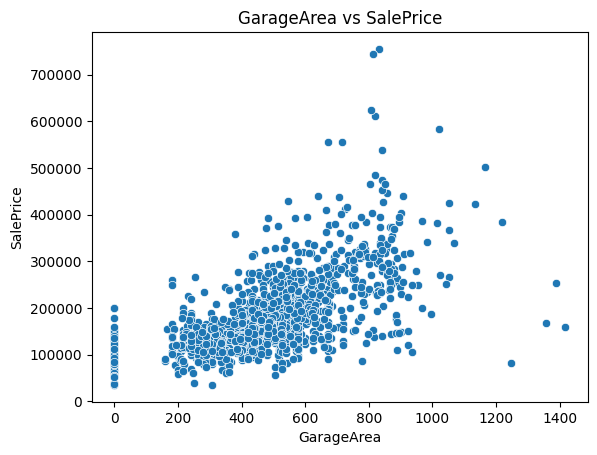

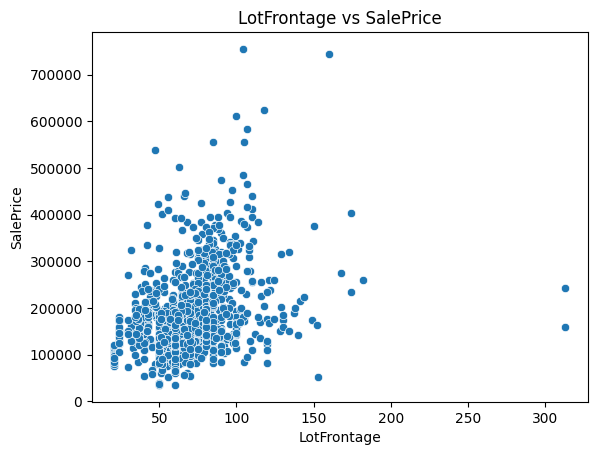

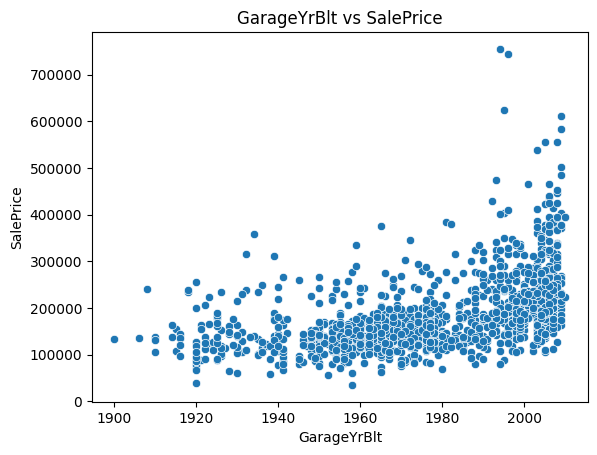

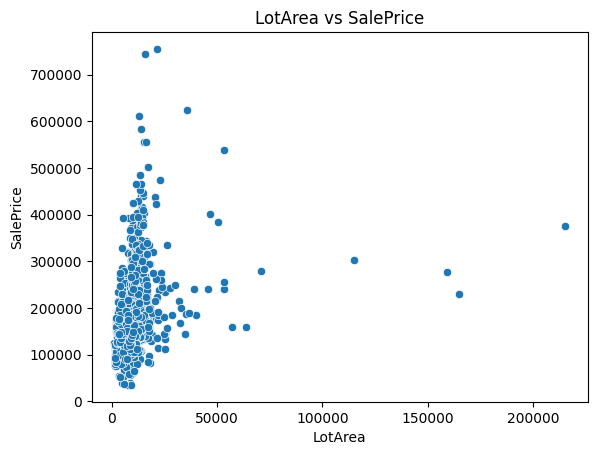

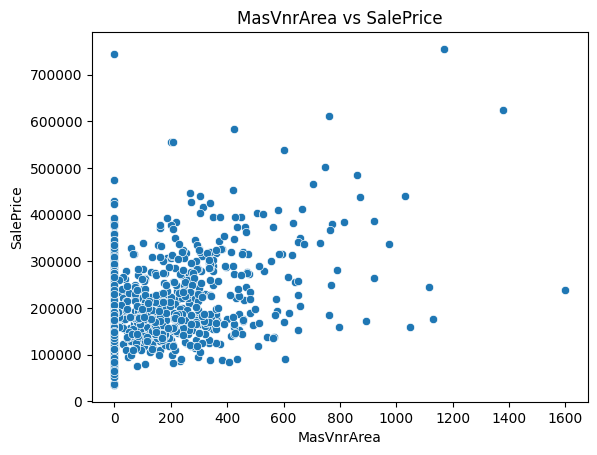

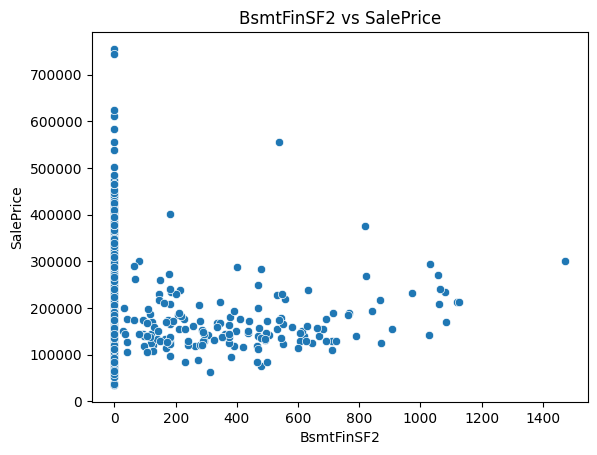

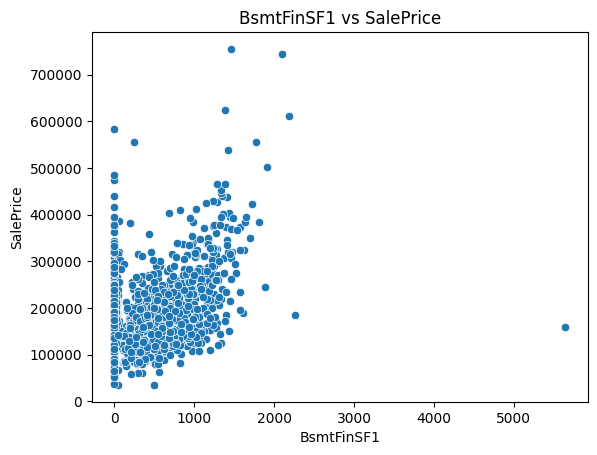

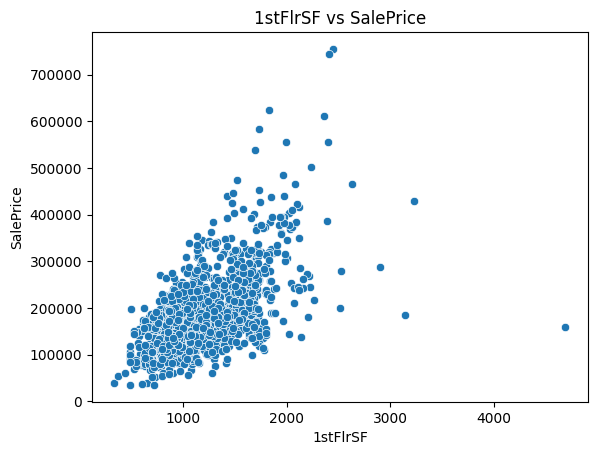

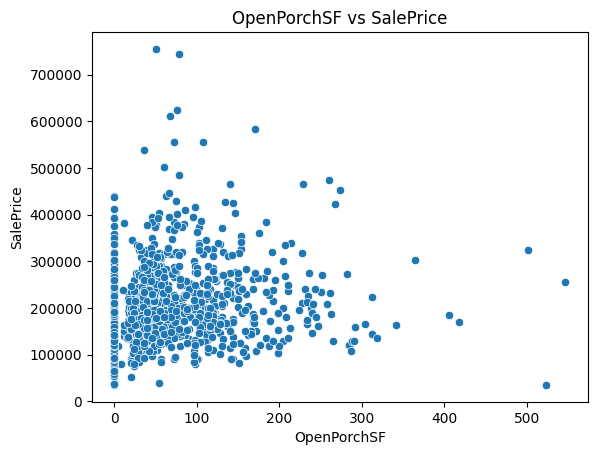

In [13]:
for col in numeric_columns:
    sns.scatterplot(x=f'{col}', y='SalePrice', data=df_train)
    plt.title(f"{col} vs SalePrice")
    plt.show()

### Check Correlation of numeric features

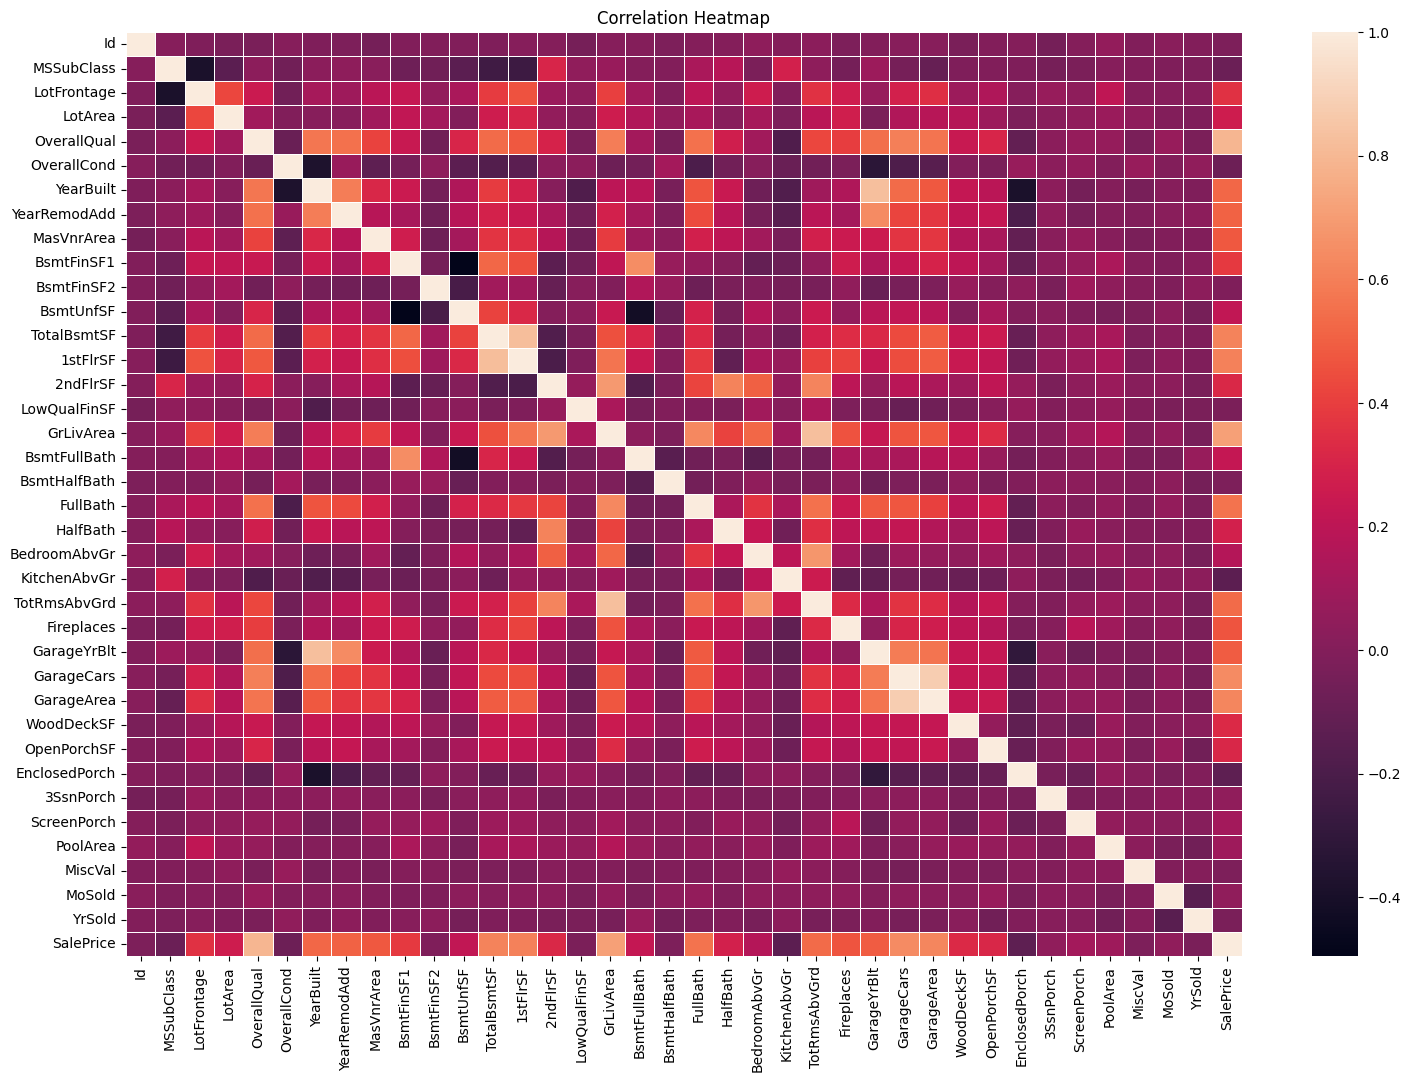

In [14]:
corr = df_train.corr(numeric_only=True)
top_corr = corr['SalePrice'].sort_values(ascending=False).head(15)

plt.figure(figsize=(18, 12))
sns.heatmap(corr, linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

### Let's solve missing value puzzle

In [15]:
none_fill_cols = [
    'PoolQC','MiscFeature','Alley','Fence','FireplaceQu',
    'GarageType','GarageFinish','GarageQual','GarageCond',
    'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
    'MasVnrType'
]

for col in none_fill_cols:
    df_train[col] = df_train[col].fillna("None")
    df_test[col] = df_test[col].fillna("None")

In [16]:
zero_fill_cols = [
    'MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
    'TotalBsmtSF','GarageCars','GarageArea'
]

for col in zero_fill_cols:
    df_train[col] = df_train[col].fillna(0)
    df_test[col] = df_test[col].fillna(0)


In [17]:
df_train['LotFrontage'] = df_train.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
df_test['LotFrontage'] = df_test.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [18]:
freq_fill_cols = ['MSZoning', 'Functional', 'Utilities', 'SaleType', 'Electrical']

for col in freq_fill_cols:
    most_common = df_train[col].mode()[0]
    df_train[col] = df_train[col].fillna(most_common)
    df_test[col] = df_test[col].fillna(most_common)

In [19]:
df_train.isnull().sum().sort_values(ascending=False).head(10)

GarageYrBlt     81
Id               0
CentralAir       0
GarageType       0
FireplaceQu      0
Fireplaces       0
Functional       0
TotRmsAbvGrd     0
KitchenQual      0
KitchenAbvGr     0
dtype: int64

In [20]:
df_train['GarageYrBlt'] = df_train['GarageYrBlt'].fillna(df_train['YearBuilt'])
df_test['GarageYrBlt'] = df_test['GarageYrBlt'].fillna(df_test['YearBuilt'])

In [21]:
df_train.isnull().sum().sort_values(ascending=False).head(10)

Id              0
CentralAir      0
GarageYrBlt     0
GarageType      0
FireplaceQu     0
Fireplaces      0
Functional      0
TotRmsAbvGrd    0
KitchenQual     0
KitchenAbvGr    0
dtype: int64

### Ordinal Encoding (Quality Ratings)
These features are ranked, not categorical, so they must NOT be one-hot encoded.

Examples:

    Ex (Excellent)

    Gd (Good)

    TA (Typical)

    Fa (Fair)

    Po (Poor)


In [22]:
quality_map = {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "None": 0, "NA": 0, None: 0}

ordinal_cols = [
    'ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC',
    'KitchenQual','FireplaceQu','GarageQual','GarageCond','PoolQC'
]

for col in ordinal_cols:
    df_train[col] = df_train[col].map(quality_map)
    df_test[col] = df_test[col].map(quality_map)



In [23]:
bsmt_exposure_map = {"Gd": 4, "Av": 3, "Mn": 2, "No": 1, "None": 0, "NA": 0, None: 0}

df_train['BsmtExposure'] = df_train['BsmtExposure'].map(bsmt_exposure_map)
df_test['BsmtExposure'] = df_test['BsmtExposure'].map(bsmt_exposure_map)

bsmt_fin_map = {"GLQ": 6, "ALQ": 5, "BLQ": 4, "Rec": 3, "LwQ": 2, "Unf": 1, "None": 0, "NA": 0, None: 0}

for col in ['BsmtFinType1','BsmtFinType2']:
    df_train[col] = df_train[col].map(bsmt_fin_map)
    df_test[col] = df_test[col].map(bsmt_fin_map)

In [24]:
functional_map = {"Typ": 7, "Min1": 6, "Min2": 5, "Mod": 4, "Maj1": 3, "Maj2": 2, "Sev": 1, "Sal": 0, "None": 0}
fence_map = {"GdPrv": 4, "MnPrv": 3, "GdWo": 2, "MnWw": 1, "None": 0}

df_train['Functional'] = df_train['Functional'].map(functional_map)
df_test['Functional'] = df_test['Functional'].map(functional_map)

df_train['Fence'] = df_train['Fence'].map(fence_map)
df_test['Fence'] = df_test['Fence'].map(fence_map)

In [25]:
df_train[ordinal_cols].head()

,ExterQual,ExterCond,BsmtQual,BsmtCond,HeatingQC,KitchenQual,FireplaceQu,GarageQual,GarageCond,PoolQC
0,4,3,4,3,5,4,0,3,3,0
1,3,3,4,3,5,3,3,3,3,0
2,4,3,4,3,5,4,3,3,3,0
3,3,3,3,4,4,4,4,3,3,0
4,4,3,4,3,5,4,3,3,3,0


#### Nominal Encoding (One-Hot Encoding)

Convert categorical features with no inherent rank into numeric form.

Examples:

    Neighborhood

    MSZoning

    Exterior1st / Exterior2nd

    BldgType

    HouseStyle

    SaleType

    SaleCondition

    RoofStyle

    Foundation

    GarageType (now partially cleaned)


In [26]:
nominal_cols = df_train.select_dtypes(include='object').columns

In [27]:
df_train = pd.get_dummies(df_train, columns=nominal_cols, drop_first=True)
df_test = pd.get_dummies(df_test, columns=nominal_cols, drop_first=True)

In [28]:
df_train, df_test = df_train.align(df_test, join='left', axis=1, fill_value=0)

In [29]:
df_train.head()
df_test.head()
df_train.shape, df_test.shape

((1460, 210), (1459, 210))

In [30]:
df_train.select_dtypes(include='object').columns

Index([], dtype='object')

#### Outlier Removal¶

In [31]:


# -----------------------------
# OUTLIER REMOVAL (must be BEFORE log/skew)
# -----------------------------
# Remove extreme large area homes priced unusually low
df_train = df_train.drop(df_train[(df_train['GrLivArea'] > 4000) & (df_train['SalePrice'] < 300000)].index)

# Remove extreme basements
df_train = df_train[df_train['TotalBsmtSF'] < 4000]

print("After outlier removal:", df_train.shape)



After outlier removal: (1458, 210)


#### Skewness Correction (Numeric Features)

Many numerical features in Ames dataset are right-skewed (long tail). If untreated:

    models over-emphasize extreme values

    residuals will not be normally distributed

    boosting models become unstable

    RMSE score worsens

Correcting skew makes patterns more linear → better predictions.


In [32]:
numeric_feats = df_train.select_dtypes(include=['int64','float64']).columns

skew_vals = df_train[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

# Select features with high skew
skewed_features = skew_vals[skew_vals > 0.75].index

print("Skewed features count:", len(skewed_features))

Skewed features count: 27


In [33]:
for col in skewed_features:
    if col != 'SalePrice':
        df_train[col] = np.log1p(df_train[col])
        df_test[col]  = np.log1p(df_test[col])

print("After skew correction:", df_train.shape, df_test.shape)


After skew correction: (1458, 210) (1459, 210)


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Special Case: Highly Extreme Features

Some features like:

    LotArea

    1stFlrSF

    GrLivArea

May need Box-Cox instead if log doesn’t normalize well, but for now log is sufficient.


/tmp/ipykernel_13/3153531478.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train['GrLivArea'])
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


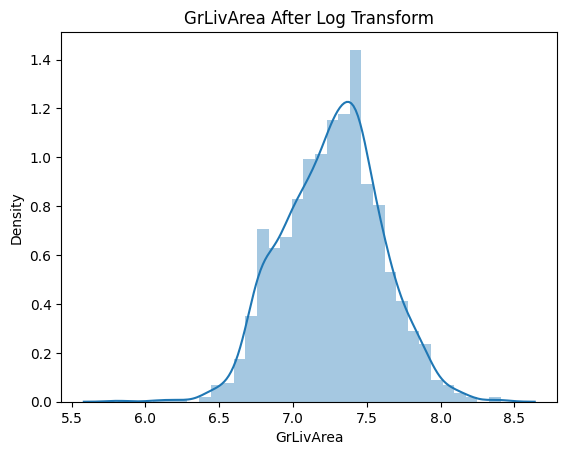

In [34]:
sns.distplot(df_train['GrLivArea'])
plt.title("GrLivArea After Log Transform")
plt.show()

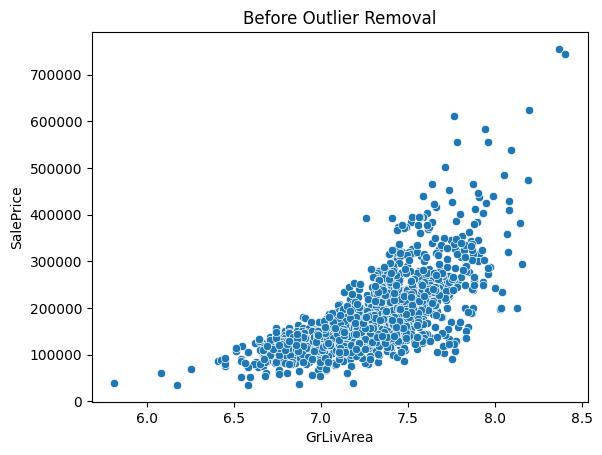

In [35]:


sns.scatterplot(x='GrLivArea', y='SalePrice', data=df_train)
plt.title("Before Outlier Removal")
plt.show()



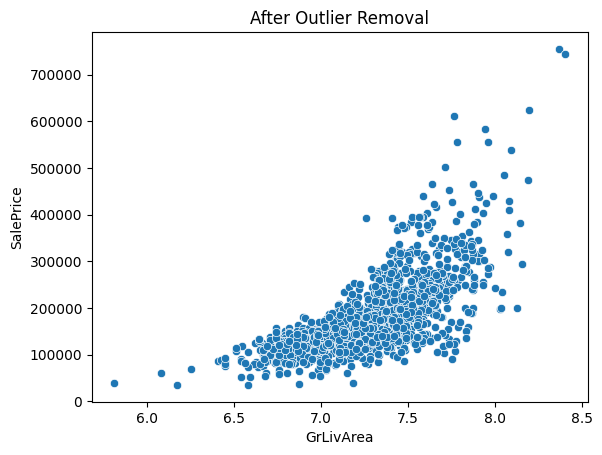

In [36]:
sns.scatterplot(x='GrLivArea', y='SalePrice', data=df_train)
plt.title("After Outlier Removal")
plt.show()

#### Feature Engineering (Model-Boosting Features)¶

Create new meaningful predictors that better represent housing value than raw columns alone.

Price is not determined by a single factor, but by interaction of:

    size × quality

    age × renovation

    finished vs unfinished spaces

    neighborhood × amenities

Engineered features capture true valuation patterns that raw data misses.

In [37]:
df_train['TotalSF'] = df_train['TotalBsmtSF'] + df_train['1stFlrSF'] + df_train['2ndFlrSF']
df_test['TotalSF'] = df_test['TotalBsmtSF'] + df_test['1stFlrSF'] + df_test['2ndFlrSF']



df_train['HouseAge'] = df_train['YrSold'] - df_train['YearBuilt']
df_test['HouseAge'] = df_test['YrSold'] - df_test['YearBuilt']

df_train['RemodAge'] = df_train['YrSold'] - df_train['YearRemodAdd']
df_test['RemodAge'] = df_test['YrSold'] - df_test['YearRemodAdd']

df_train['GarageAge'] = df_train['YrSold'] - df_train['GarageYrBlt']
df_test['GarageAge'] = df_test['YrSold'] - df_test['GarageYrBlt']

df_train['QualGrLiv'] = df_train['OverallQual'] * df_train['GrLivArea']
df_test['QualGrLiv'] = df_test['OverallQual'] * df_test['GrLivArea']

df_train['QualTotalSF'] = df_train['OverallQual'] * df_train['TotalSF']
df_test['QualTotalSF'] = df_test['OverallQual'] * df_test['TotalSF']


df_train['BathTotal'] = df_train['FullBath'] + (0.5 * df_train['HalfBath'])
df_test['BathTotal'] = df_test['FullBath'] + (0.5 * df_test['HalfBath'])



df_train['BsmtFinRatio'] = df_train['BsmtFinSF1'] / (df_train['TotalBsmtSF'] + 1)
df_test['BsmtFinRatio'] = df_test['BsmtFinSF1'] / (df_test['TotalBsmtSF'] + 1)



df_train['TotalPorchSF'] = df_train['OpenPorchSF'] + df_train['EnclosedPorch'] + df_train['3SsnPorch'] + df_train['ScreenPorch']
df_test['TotalPorchSF'] = df_test['OpenPorchSF'] + df_test['EnclosedPorch'] + df_test['3SsnPorch'] + df_test['ScreenPorch']

df_train['TotalRooms'] = df_train['TotRmsAbvGrd'] + df_train['BedroomAbvGr'] + df_train['KitchenAbvGr']
df_test['TotalRooms'] = df_test['TotRmsAbvGrd'] + df_test['BedroomAbvGr'] + df_test['KitchenAbvGr']



In [38]:
y = np.log1p(df_train['SalePrice'])   # target (log-transform)
X = df_train.drop('SalePrice', axis=1)

print("X:", X.shape)
print("y:", y.shape)

X: (1458, 219)
y: (1458,)


In [39]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [40]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [41]:
### RMSE applied on log-transformed SalePrice
def rmse_cv(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y,
                                    scoring="neg_mean_squared_error",
                                    cv=kfold))
    return rmse.mean()

In [42]:
lin_reg = LinearRegression()
rmse_linear = rmse_cv(lin_reg, X_scaled, y)
print("Linear Regression RMSE:", rmse_linear)

Linear Regression RMSE: 183618939714.16052


In [43]:
ridge = Ridge(alpha=10)
rmse_ridge = rmse_cv(ridge, X_scaled, y)
print("Ridge RMSE:", rmse_ridge)

Ridge RMSE: 0.12124901224336448


In [44]:
lasso = Lasso(alpha=0.0005, max_iter=5000)
rmse_lasso = rmse_cv(lasso, X_scaled, y)
print("LASSO RMSE:", rmse_lasso)

LASSO RMSE: 0.11738853537172407


In [45]:
elastic = ElasticNet(alpha=0.0005, l1_ratio=0.7, max_iter=5000)
rmse_elastic = rmse_cv(elastic, X_scaled, y)
print("ElasticNet RMSE:", rmse_elastic)

ElasticNet RMSE: 0.11844634931955753


In [46]:
## LightGBM (Top Performer)
from lightgbm import LGBMRegressor

lgb_model = LGBMRegressor(
    objective='regression',
    boosting_type='gbdt',
    learning_rate=0.01,
    n_estimators=5000,
    num_leaves=6,
    max_depth=-1,
    reg_alpha=0.1,
    reg_lambda=0.1,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42
)

rmse_lgb = rmse_cv(lgb_model, X, y)
print("LightGBM RMSE:", rmse_lgb)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4958
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 145
[LightGBM] [Info] Start training from score 12.023362
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4956
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 147
[LightGBM] [Info] Start training from score 12.026498
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM]

In [47]:
## XGBoost (Second Best)

from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    learning_rate=0.01,
    n_estimators=4000,
    max_depth=3,
    subsample=0.6,
    colsample_bytree=0.6,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    tree_method='hist'
)

rmse_xgb = rmse_cv(xgb_model, X, y)
print("XGBoost RMSE:", rmse_xgb)

XGBoost RMSE: 0.11582353526517664


In [48]:
from catboost import CatBoostRegressor

cat_model = CatBoostRegressor(
    learning_rate=0.01,
    depth=5,
    n_estimators=5000,
    loss_function='RMSE',
    verbose=False,
    random_state=42
)

rmse_cat = rmse_cv(cat_model, X, y)
print("CatBoost RMSE:", rmse_cat)

CatBoost RMSE: 0.1146062906818873


In [49]:
print("LASSO RMSE:", rmse_lasso)
print("ElasticNet RMSE:", rmse_elastic)
print("LightGBM RMSE:", rmse_lgb)
print("XGBoost RMSE:", rmse_xgb)
print("CatBoost RMSE:", rmse_cat)

LASSO RMSE: 0.11738853537172407
ElasticNet RMSE: 0.11844634931955753
LightGBM RMSE: 0.12001024128165197
XGBoost RMSE: 0.11582353526517664
CatBoost RMSE: 0.1146062906818873


In [50]:
# Train final model with best full settings
final_model = CatBoostRegressor(
    learning_rate=0.01,
    depth=5,
    n_estimators=5000,
    loss_function='RMSE',
    verbose=False,
    random_state=42
)

# Fit on full training set (entire X and y)
final_model.fit(X, y)

# Predict on test
final_preds_log = final_model.predict(df_test)

# Convert back from log SalePrice → real values
final_preds = np.expm1(final_preds_log)

# Create submission file
submission = pd.DataFrame({
    "Id": df_test["Id"].tolist(),
    "SalePrice": np.array(final_preds, dtype=np.int64).tolist()
})

submission.to_csv("submission.csv", index=False)
submission.head()

,Id,SalePrice
0,1461,127164
1,1462,165761
2,1463,185582
3,1464,196957
4,1465,187933
